In [1]:
from datetime import datetime
import pickle

import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
CSV_PATH = r'C:\Users\guil\Downloads\MTA_Bus_Hourly_Ridership__Beginning_February_2022_20240121.csv'
df = pd.read_csv(CSV_PATH)

除去标题行：27740895 rows x 6 columns
- **transit_timestamp**: from *2022/2/1* to *2024/1/20*, *01:00AM* to *12:00PM*, 1 hour interval
- **bus_route**: B1 to B100, and more(Q1, Q2, ...)
- **payment_method**
- **fare_class_category**
- **ridership**
- **transfers**

需将12小时制时间转换为时间戳以排序

payment_method 和 fare_class_category 是我们不关心的特征，并且认为流量为 ridership 和 transfers 之和

将各个 bus_route 作为最终结果中的 node，最终每个时空节点的流量是各个 payment_method 和 fare_class_category 下的流量相加

处理需要30分钟左右：

In [4]:
time_slots_12 = df['transit_timestamp'].unique()
time_slot_map = {time: idx for idx, time in enumerate(time_slots_12)}
bus_routes = df['bus_route'].unique()
bus_route_map = {route: idx for idx, route in enumerate(bus_routes)}

data = np.zeros(shape=(len(time_slots_12), len(bus_routes)), dtype=np.int32)

for _, row in tqdm(df.iterrows(), total = len(df)):
    flow = row['ridership'] + row['transfers']
    time = row['transit_timestamp']
    time_idx = time_slot_map[time] 
    route = row['bus_route']
    route_idx = bus_route_map[route]
    data[time_idx][route_idx] = flow

result_df = pd.DataFrame(data, columns=bus_routes)

# Convert 12-hour to timestamp inorder to sort, then convert back to 24-hour
result_df.insert(0, 'time', time_slots_12)
timestamp = [pd.to_datetime(time, format='%m/%d/%Y %I:%M:%S %p').timestamp() for time in time_slots_12]
result_df['time'] = timestamp
result_df.sort_values(by=['time'], inplace=True)
time_slots_24 = [datetime.utcfromtimestamp(ts).strftime('%m/%d/%Y %H:%M:%S') for ts in timestamp]
result_df['time'] = time_slots_24

# Save data as CSV
result_df.to_csv('data.csv', index=False)
# Save data as pickle
DataFormat = {
    "TimeRange": ['2022-2-1', '2024-1-20'],    # 起止时间 str eg:['2016-10-01', '2016-11-30']
    "TimeFitness": 60,  # 时间粒度 int 单位为min
    "Node": {
        "TrafficNode": result_df.values[:, 1:],  # np.array, with shape [time_slots, num-of-node] eg:(1440,256) 
        "TrafficMonthlyInteraction": [], # np.array, With shape [month, num-of-node. num-of-node]
        "StationInfo": [],  # list of [id, build-time, lat, lng, name], eg:['0', 0, 34.210542575000005, 108.91390095, 'grid_0']
        "POI": []
    },
    "Grid": {
        "TrafficGrid": [], # with shape [slots, num-of-node. num-of-node] eg:(120, 256, 256)
        "GridLatLng": [],  # 对角线点的经纬度 eg:[[34.20829427, 108.91118]]
        "POI": []
    },
    "ExternalFeature": {
        "Weather": []
    }
}

with open('data.pkl', 'wb') as f:
    pickle.dump(DataFormat, f)

100%|██████████| 27740895/27740895 [29:23<00:00, 15734.63it/s]


data: [15618, 331]

In [5]:
print(data.shape)

print(result_df.head())
print(result_df.info())

(17040, 331)
                     time  B1  B100  B103  B11  B12  B13  B14  B15  B16  ...  \
6804  02/01/2022 13:00:00   4     1     8    3    6    7    2   31    1  ...   
6805  02/01/2022 14:00:00   2     0     4    1    2    1    1    9    0  ...   
7877  02/01/2022 15:00:00   2     0     4    0    4    0    1   13    0  ...   
6806  02/01/2022 16:00:00   1     0     0    0    3    0    1   13    0  ...   
6807  02/01/2022 17:00:00   4     0     0    7   11    3    1   54    0  ...   

      X27  X38  X63  X64  X68  X80  X81  H.R.L.  Q00  POLICE / SHUTTLE / BUSES  
6804    1    0    0    0    0    0    0       0    0                         0  
6805    0    0    0    0    0    0    0       0    0                         0  
7877    0    0    0    0    0    0    0       0    0                         0  
6806    0    0    0    0    0    0    0       0    0                         0  
6807    0    0    0    0    0    0    0       0    0                         0  

[5 rows x 332 colum

取B1这个节点进行可视化

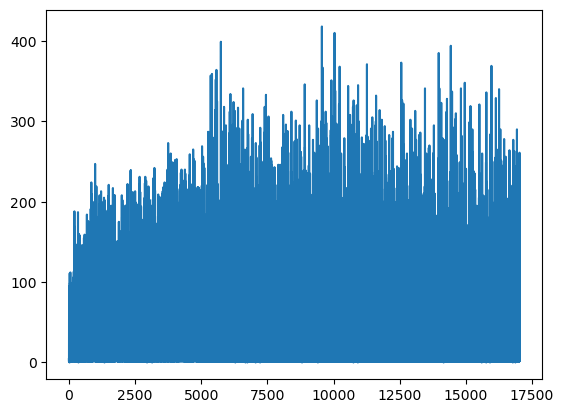

In [11]:
import matplotlib.pyplot as plt
plt.plot(DataFormat['Node']['TrafficNode'][:, 0])
plt.show()

## StationInfo
StationInfo 没法从之前的表格中获取，需要读取另一个文件，借助 geopandas 处理得到

新文件中包含的 route_id 并不完全等同于我们所需要的路线

In [2]:
gdf = gpd.read_file(r'shp\bus_routes_nyc_dec2019.shp').to_crs(epsg=4326)
gdf['centroid'] = gdf['geometry'].centroid
gdf

f:\miniconda3\envs\UCTB\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


,route_id,route_dir,route_shor,route_long,color,geometry,centroid
0,M101,M101_0,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.94883 40.78586, -73.9483...",POINT (-73.95455 40.79097)
1,M101,M101_1,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.93779 40.80386, -73.9379...",POINT (-73.95599 40.79057)
2,M102,M102_0,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.99003 40.72961, -73.9899...",POINT (-73.95775 40.77864)
3,M102,M102_1,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.93594 40.82119, -73.9358...",POINT (-73.96047 40.77588)
4,M103,M103_0,M103,East Harlem - City Hall,#B933AD,"MULTILINESTRING ((-73.93533 40.80436, -73.9348...",POINT (-73.96875 40.75806)
...,...,...,...,...,...,...,...
498,Q69,Q69_0,Q69,21 St - Ditmars Blvd,#00AEEF,"LINESTRING (-73.93944 40.74935, -73.93954 40.7...",POINT (-73.92109 40.76566)
499,Q69,Q69_1,Q69,21 St - Ditmars Blvd,#00AEEF,"LINESTRING (-73.88770 40.76522, -73.88808 40.7...",POINT (-73.91907 40.76764)
500,Q70+,Q70+_0,Q70-SBS,LaGuardia Link,#EE352E,"MULTILINESTRING ((-73.90213 40.74576, -73.9021...",POINT (-73.88589 40.76244)
501,Q72,Q72_0,Q72,Junction Blvd - Laguardia Main Term,#B933AD,"MULTILINESTRING ((-73.86284 40.73079, -73.8634...",POINT (-73.87131 40.75581)


同一 route_id 下还会因 route_dir 的不同而有多行数据，因此需要将其重心取平均值作为最终 route_id 的坐标

In [16]:
df = pd.read_csv('data.csv')
target_route_id = df.columns[1:]
given_route_id = gdf['route_id'].unique()

stationInfoList = []
stationsList = gpd.GeoDataFrame()
for route in tqdm(target_route_id):
    if route not in given_route_id:
        df.drop(columns=[route], inplace=True)
        continue
    stations = gdf[gdf['route_id'] == route]
    # [id, build-time, lat, lng, name]
    stationInfo = [
        route, 
        '2022-2-1', 
        stations['centroid'].y.mean(), 
        stations['centroid'].x.mean(), 
        stations['route_long'].unique()[0]
    ]
    stationInfoList.append(stationInfo)
    stationsList = stationsList.append(stations)

print(df)
print(stationInfoList)

100%|██████████| 331/331 [00:01<00:00, 201.84it/s]

                      time  B1  B100  B103  B11  B12  B13  B14  B15  B16  ...  \
0      02/01/2022 05:00:00   4     1     8    3    6    7    2   31    1  ...   
1      02/01/2022 06:00:00   2     0     4    1    2    1    1    9    0  ...   
2      02/01/2022 07:00:00   2     0     4    0    4    0    1   13    0  ...   
3      02/01/2022 08:00:00   1     0     0    0    3    0    1   13    0  ...   
4      02/01/2022 09:00:00   4     0     0    7   11    3    1   54    0  ...   
...                    ...  ..   ...   ...  ...  ...  ...  ...  ...  ...  ...   
17035  01/06/2024 03:00:00   6    10    84   28   35    4    3   25    3  ...   
17036  12/19/2023 03:00:00  39     3    48   35    2   31   12   33   10  ...   
17037  12/26/2023 01:00:00  17     2     1    7    2    6    2   19    9  ...   
17038  12/30/2023 02:00:00   7     3     3    5    1    3    2    3    4  ...   
17039  12/17/2023 03:00:00   2     3     3    1    4    4    1    8    3  ...   

       S78  S94  S81  S84  

最终只剩下226个 route_id 是有效的

f:\miniconda3\envs\UCTB\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

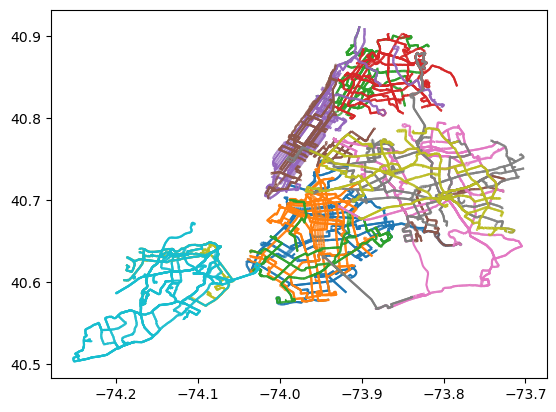

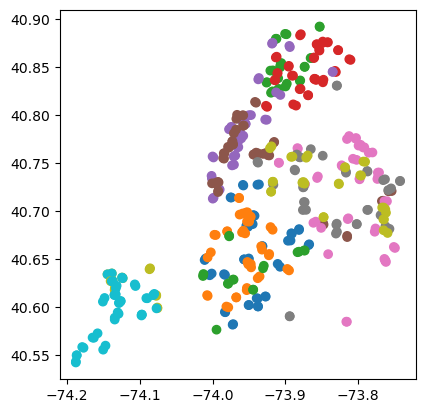

In [19]:
stationsList.plot('route_id')
stationsList.set_geometry('centroid').plot('route_id')

### 保存数据
该数据相较之前的数据多了节点的坐标信息，但是节点数减少了

In [22]:
# Save data as CSV
df.to_csv('data_with_station.csv', index=False)
# Save data as pickle
DataFormat = {
    "TimeRange": ['2022-2-1', '2024-1-20'],    # 起止时间 str eg:['2016-10-01', '2016-11-30']
    "TimeFitness": 60,  # 时间粒度 int 单位为min
    "Node": {
        "TrafficNode": df.values[:, 1:],  # np.array, with shape [time_slots, num-of-node] eg:(1440,256) 
        "TrafficMonthlyInteraction": [], # np.array, With shape [month, num-of-node. num-of-node]
        "StationInfo": stationsList,  # list of [id, build-time, lat, lng, name], eg:['0', 0, 34.210542575000005, 108.91390095, 'grid_0']
        "POI": []
    },
    "Grid": {
        "TrafficGrid": [], # with shape [slots, num-of-node. num-of-node] eg:(120, 256, 256)
        "GridLatLng": [],  # 对角线点的经纬度 eg:[[34.20829427, 108.91118]]
        "POI": []
    },
    "ExternalFeature": {
        "Weather": []
    }
}

with open('data_with_station.pkl', 'wb') as f:
    pickle.dump(DataFormat, f)